In [96]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import graphingFunctions as gf
import modelingFunctions as mf
importlib.reload(gf)
importlib.reload(mf)

<module 'modelingFunctions' from 'c:\\Users\\zacha\\Documents\\co3093-cw\\modelingFunctions.py'>

In [97]:
def categorizeNeighborhood(df):
    group = df.groupby("NEIGHBORHOOD")["SALE_PRICE"].mean().reset_index()
    group = group.rename(columns={"SALE_PRICE": "AVG_SALE_PRICE"})
    
    df = pd.merge(df, group, on="NEIGHBORHOOD", how="left")
    
    bins = [-np.inf, group["AVG_SALE_PRICE"].quantile(1/3), group["AVG_SALE_PRICE"].quantile(2/3), np.inf]
    n_cat = pd.cut(df["AVG_SALE_PRICE"], bins=bins, labels=[1,2,3])
    df = df.join(n_cat, rsuffix='_CATEGORY')
    return df

In [98]:
def markOutliersPerNieghborhood(df):
    groupedDF = df.groupby("NEIGHBORHOOD")
    t = np.zeros(df.shape[0])
    for n, g in groupedDF:
        q1 = g['lnprice'].quantile(0.25)
        q3 = g['lnprice'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        #Saleprice
        q1SP = g['SALE_PRICE'].quantile(0.25)
        q3SP = g['SALE_PRICE'].quantile(0.75)
        iqrSP = q3SP - q1SP
        lower_boundSP = q1SP - 1.5 * iqrSP
        upper_boundSP = q3SP + 1.5 * iqrSP
        for i, r in g.iterrows():
            if not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0):
                t[i] = 1
            if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_boundSP or r['SALE_PRICE'] >= upper_boundSP and r['SALE_PRICE']!=0):
                t[i] = 1
    
    #Overall
    q1 = df['lnprice'].quantile(0.25)
    q3 = df['lnprice'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    q1SP = df['SALE_PRICE'].quantile(0.25)
    q3SP = df['SALE_PRICE'].quantile(0.75)
    iqrSP = q3SP - q1SP
    lower_boundSP = q1SP - 1.5 * iqrSP
    upper_boundSP = q3SP + 1.5 * iqrSP
    for i, r in df.iterrows():
        if not pd.isnull(r['lnprice']) and (r['lnprice'] <= lower_bound or r['lnprice'] >= upper_bound and r['lnprice']!=0):
            t[i] = 1
        if not pd.isnull(r['SALE_PRICE']) and (r['SALE_PRICE'] <= lower_boundSP or r['SALE_PRICE'] >= upper_boundSP and r['SALE_PRICE']!=0):
            t[i] = 1
            

    df['outlier']=t
    return df


def fillYearBuilt(df):
    #copy df to avoid data corruption
    dfComplete=df.copy()

    #Replace 0's and invalid data
    dfComplete["YEAR_BUILT"]=dfComplete["YEAR_BUILT"].replace(0,np.NaN)
    dfComplete.loc[dfComplete["YEAR_BUILT"] < 1800, "YEAR_BUILT"] = np.nan

    #Get median based on block and neighborhood and Round to nearest year
    median=dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])['YEAR_BUILT'].median()
    median_rounded = median.round().astype('Int64')

    #Replace NA with median
    dfComplete["YEAR_BUILT"].fillna(dfComplete.groupby(['BLOCK', 'NEIGHBORHOOD'])["YEAR_BUILT"].transform(lambda x: x.fillna(median_rounded[x.name])), inplace=True)
    
    return dfComplete

In [99]:
def step2_clean():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print(df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')

    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)

    #Set missing Sale price to avoid log issues before outlier
    df["SALE_PRICE"]=df["SALE_PRICE"].replace(0, np.NaN)
    
    #Drop unecessary columns and duplicates
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    #Clean up yearbuilt missing data
    df=fillYearBuilt(df)
      
    #Create Log and Mark outliers before Imputation
    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['lnprice'],inplace=True)
    
    #Ensure imputated data is set to NaN
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)

    #Impute data
    df=mf.itImputations(df,['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE'])
    
    #Ensure any remaining missing data is removed
    df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']]=df[['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'SALE_PRICE']].replace(0,np.NaN)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    #Run outliers again to remove any outliers introduced by imputation
    df['lnprice']=np.log(df["SALE_PRICE"])
    df=markOutliersPerNieghborhood(df)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    #print new shape and null summary
    print(df.shape, df.isnull().sum())
    
    #return cleaned data
    return df

In [100]:
def normalize(df, num_cols):
    df_norm = df.copy()
    for col in num_cols:
        df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
    return df_norm

In [101]:
df = step2_clean()
df.reset_index(drop=True,inplace=True)

#Set type lists
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE','lnprice']
categorical=['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']

#Normalize the data
dfnorm=normalize(df, numerical)


(27395, 21)
RELOADEDV2


c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(16878, 19) NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
lnprice                           0
dtype: int64


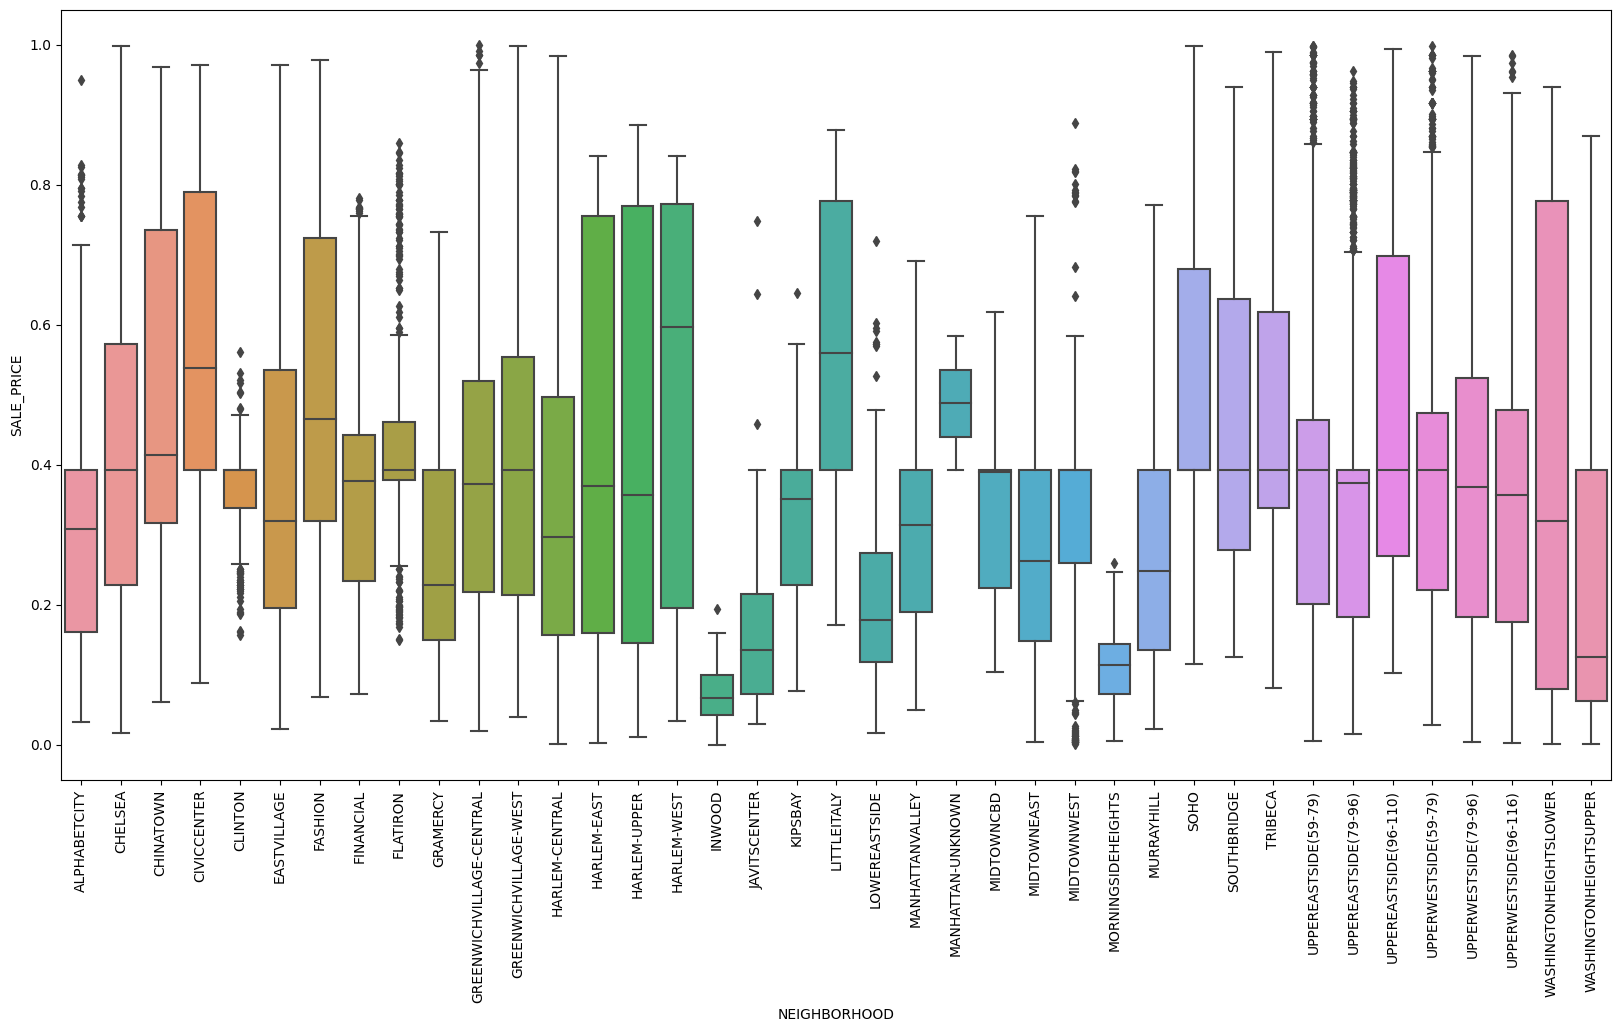

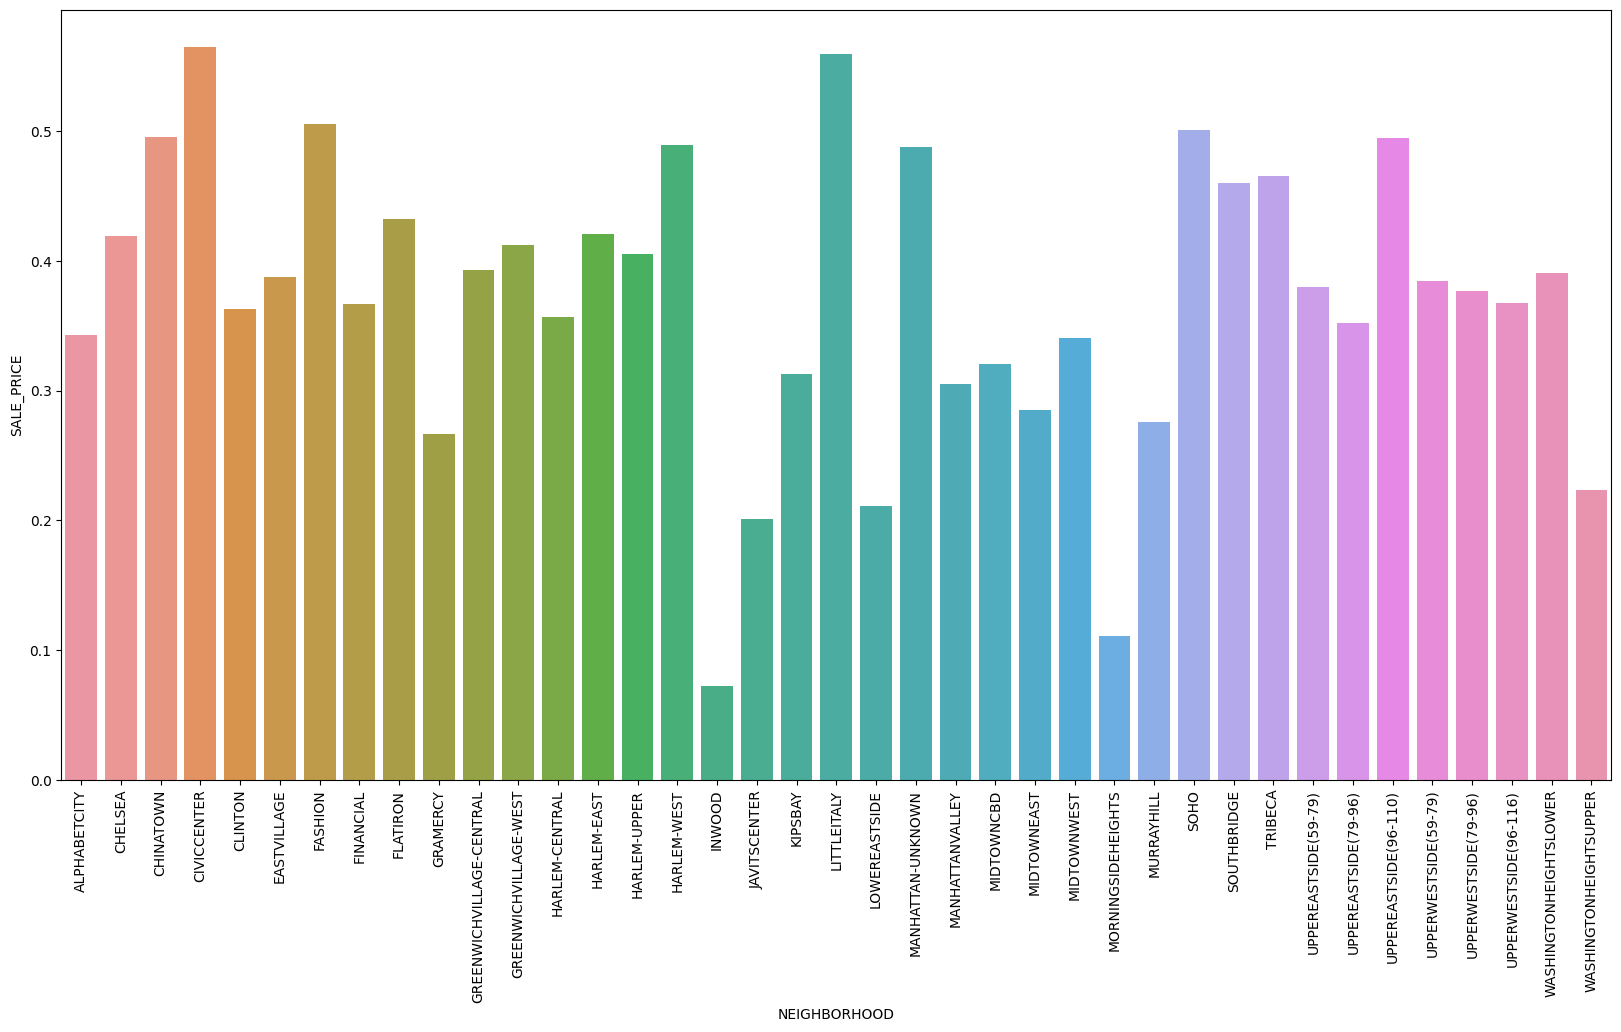

In [102]:
#Check box and average to ensure cleaning left a good selection
gf.boxPlot(dfnorm, 'SALE_PRICE', 'NEIGHBORHOOD')
gf.averagePrice(dfnorm, 'SALE_PRICE', 'NEIGHBORHOOD')


In [140]:

###LINEAR REGRESSION MODEL###
def linearRegressionModel(df,target, select_features):
# Select predictors
    
    X = df[select_features]

    # Target variable
    y = df[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    data={}
    data['X_test'], data['X_train'], data['y_test'], data['y_train']=X_test, X_train, y_test, y_train
    data['X'],data['y']=X,y
    data['model']=model
    data['select_features']=select_features
    data['target']=target 
    return data

def modelEvalLR(data):
    X_test, X_train, y_test, y_train = data['X_test'], data['X_train'], data['y_test'], data['y_train']
    model=data['model']
    # Evaluate the model on the test set aand get RMSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: {:.2f}".format(rmse))

    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(model, data['X'], data['y'], cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

    print("Y-axis intercept {:6.4f}".format(model.intercept_))
    print("Weight coefficients:")
    for feat, coef in zip(data['select_features'], model.coef_):
        print(" {:>20}: {:6.4f}".format(feat, coef))
    # The value of R^2
    print("R squared for the training data is {:4.3f}".format(model.score(X_train,
    y_train)))
    print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))

    predVAct(y_pred,y_test)
    showResiduals(y_test,y_pred,X_test, model)
    

def mse(df, pred, obs):
    n = df.shape[0]
    return sum((df[pred]-df[obs])**2)/n

def predVAct(y_pred,y_test, model_type='Linear'):
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Add a regression line to the plot
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')

    # Set axis labels and title
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(model_type+' Regression Model')

    # Show the plot
    plt.show()

def showResiduals(y_test,y_pred,X_test, model):
    # Plot histogram of residuals
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True)
    plt.title("Risiduals Histogram")
    plt.show()

    plt.title("Residuals")
    pred=model.predict(X_test)
    res=(y_test-pred)
    plt.plot(res, 'go')
    plt.show()

Root Mean Squared Error: 0.06
Cross-validation scores:  [0.96745216 0.71058731 0.96811354 0.97931802 0.95114695]
Mean cross-validation score: 0.92
Y-axis intercept 0.8493
Weight coefficients:
    RESIDENTIAL_UNITS: -3.2194
     COMMERCIAL_UNITS: -1.2568
          TOTAL_UNITS: 3.1887
     LAND_SQUARE_FEET: 5.8371
    GROSS_SQUARE_FEET: -6.0381
R squared for the training data is 0.920
Score against test data: 0.926


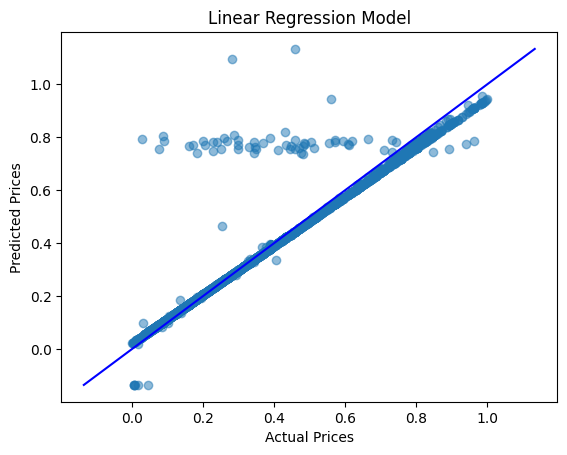

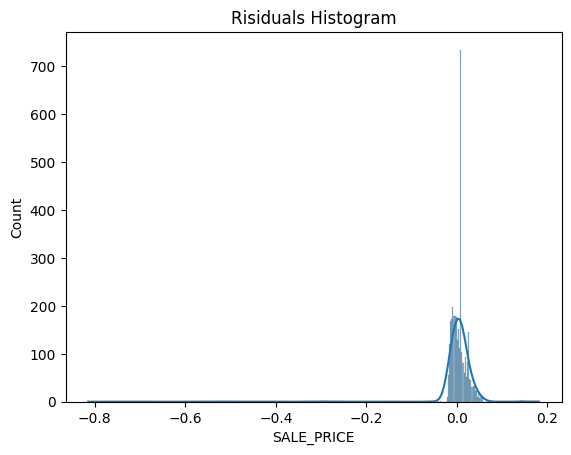

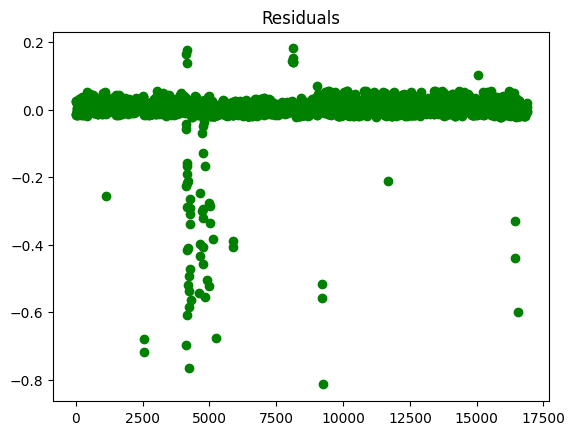

In [141]:
features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
modelLRData=linearRegressionModel(dfnorm, 'SALE_PRICE', features)
modelEvalLR(modelLRData)


In [134]:
from sklearn.ensemble import RandomForestRegressor

def randomForestModel(df, target, select_features):
    # Select predictors
    X = df[select_features]

    # Target variable
    y = dfnorm[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    data={}
    data['X_test'], data['X_train'], data['y_test'], data['y_train']=X_test, X_train, y_test, y_train
    data['X'],data['y']=X,y
    data['model']=model
    data['select_features']=select_features
    data['target']=target 
    return data


def modelEvalRF(data):
    X_test, X_train, y_test, y_train = data['X_test'], data['X_train'], data['y_test'], data['y_train']
    model=data['model']
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: {:.2f}".format(rmse))

    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(model, data['X'], data['y'], cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

    print("Feature importances:")
    for feat, importance in zip(data['select_features'], model.feature_importances_):
        print(" {:>20}: {:6.4f}".format(feat, importance))

    # The value of R^2
    print("R squared for the training data is {:4.3f}".format(model.score(X_train, y_train)))
    print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))

    predVAct(y_pred, y_test)




Root Mean Squared Error: 0.05
Cross-validation scores:  [0.95656646 0.78288296 0.96852938 0.98702254 0.95208678]
Mean cross-validation score: 0.93
Feature importances:
    RESIDENTIAL_UNITS: 0.0048
     COMMERCIAL_UNITS: 0.0021
          TOTAL_UNITS: 0.0050
     LAND_SQUARE_FEET: 0.0336
    GROSS_SQUARE_FEET: 0.9546
R squared for the training data is 0.989
Score against test data: 0.936


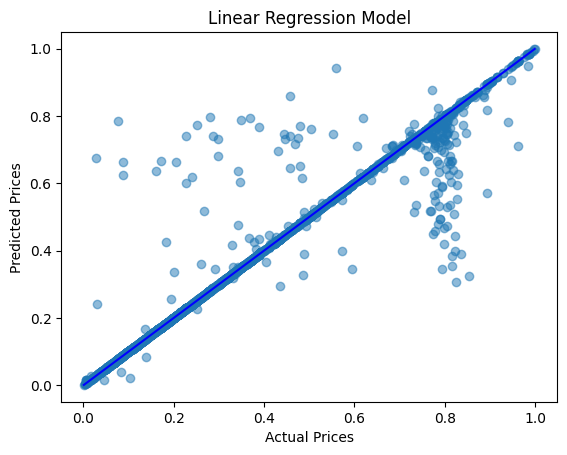

In [135]:
rfModelData=randomForestModel(df,'SALE_PRICE', features)
modelEvalRF(rfModelData)

In [131]:
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE', 'lnprice']
model = KMeans(n_clusters=8)
model.fit(dfnorm[numerical])

## J score
print('J-score = ', model.inertia_)
#print(' score = ', model.score(df_norm))
## include the labels into the data
print(model.labels_)


labels = model.labels_
md = pd.Series(labels)
dfnorm['clust'] = md



c:\Users\zacha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


J-score =  53.12080435638619
[2 7 2 ... 1 2 2]


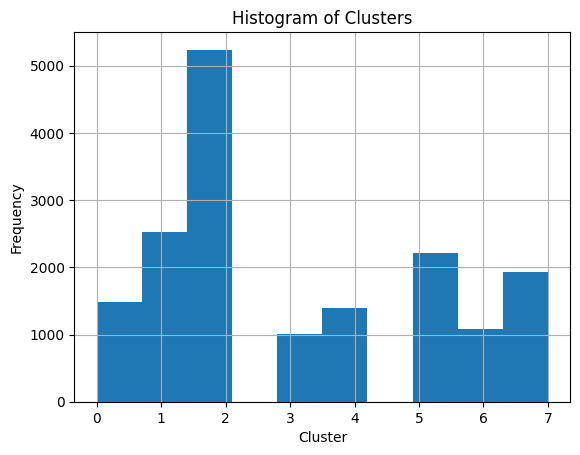

C:\Users\zacha\AppData\Local\Temp\ipykernel_12148\2308593350.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfnorm.groupby('clust').mean()


,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,lnprice,pred
clust,,,,,,,,,,,,,
0,1134.251517,459.472690,10033.351315,0.014520,0.003026,0.015659,0.023018,0.030642,1932.575860,2.038436,0.835716,0.938050,0.798024
1,1136.363816,548.555424,10030.364212,0.001281,0.000124,0.001331,0.057408,0.162829,1950.097387,2.006730,0.188386,0.477655,0.201179
2,1108.283368,1001.637388,10034.077525,0.002168,0.000958,0.002631,0.047528,0.122733,1958.159061,2.171663,0.389719,0.690180,0.385855
3,1458.191889,311.950544,10031.425321,0.001149,0.000538,0.001353,0.064720,0.191966,1939.484669,2.066271,0.047850,0.185941,0.067906
4,1085.368459,758.606452,10031.043728,0.002958,0.000453,0.003146,0.039997,0.093897,1953.678853,2.051613,0.522956,0.782867,0.515752
5,1107.628378,745.264414,10030.028829,0.002718,0.000490,0.002904,0.052667,0.143548,1954.881081,2.010811,0.279788,0.589035,0.289860
6,1084.003693,680.444137,10033.590028,0.004125,0.002061,0.004904,0.031743,0.062892,1947.785780,2.134811,0.679288,0.868796,0.654609
7,1230.442538,432.638066,10033.730629,0.001460,0.000520,0.001664,0.061300,0.177907,1946.689548,2.017681,0.112680,0.349854,0.132846


In [87]:


## histogram of the clusters
plt.hist(dfnorm['clust'])
plt.title('Histogram of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.grid()
plt.show()

dfnorm.groupby('clust').mean()

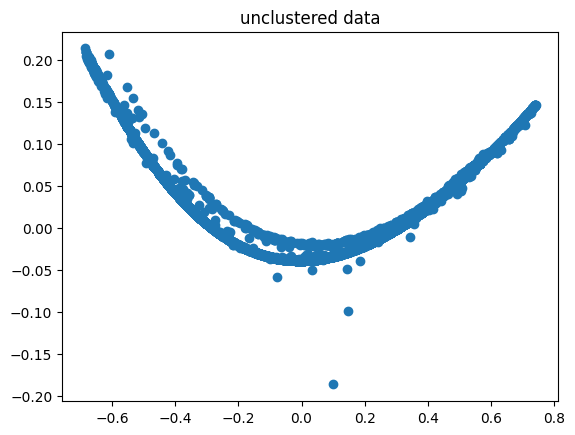

In [88]:
pca_data = PCA(n_components=2).fit(dfnorm[numerical])
pca_2d = pca_data.transform(dfnorm[numerical])
plt.scatter(pca_2d[:,0], pca_2d[:,1])
plt.title('unclustered data')
plt.show()

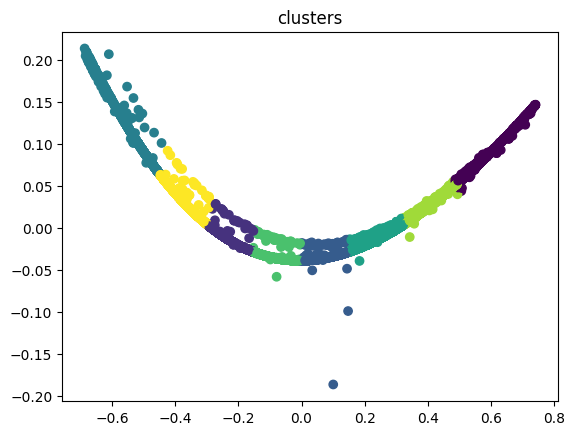

In [89]:
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
plt.title('clusters')
plt.show()


Plotting elbow method...
2 596.5601892742303
4 143.0886164318694
6 74.84846360814122
8 53.03703865618307
10 39.53557935127235
12 32.08951145635838
14 27.022389108920578
16 23.15399462387625
18 20.181364118377594


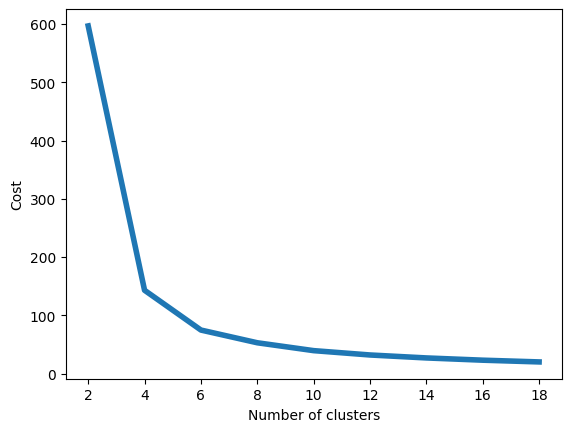

DONE


In [90]:


def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 20, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
elbow(dfnorm[numerical])



In [91]:
def localRegressors(df, clusters, features, target):
    model_dict={}
    cluster_dict={}
    for cluster in range(clusters):
        clustData=df[df['clust'] == cluster].copy()
        if clustData.empty:
            continue
        x=clustData[features]
        y=clustData[target]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(x_train,y_train)
        model_dict[cluster]=model
        cluster_dict[cluster]={'x':x,'x_train':x_train, 'x_test':x_test, 'y':y, 'y_train':y_train, 'y_test':y_test}
    
    return model_dict, cluster_dict
features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']
models, clusters=localRegressors(dfnorm, 8, features, 'SALE_PRICE')
print(models)

{0: RandomForestRegressor(random_state=42), 1: RandomForestRegressor(random_state=42), 2: RandomForestRegressor(random_state=42), 3: RandomForestRegressor(random_state=42), 4: RandomForestRegressor(random_state=42), 5: RandomForestRegressor(random_state=42), 6: RandomForestRegressor(random_state=42), 7: RandomForestRegressor(random_state=42)}


In [92]:
def testClusters(df, models,clusters):
    for cluster, model in models.items():
        clustData=clusters[cluster]
        x = clustData['x']
        y = clustData['y']
        x_test=clustData['x_test']
        x_train=clustData['x_train']
        y_test=clustData['y_test']
        y_train=clustData['y_train']
        cv_scores = cross_val_score(model, x, y, cv=5)
        print("Cluster {} - Cross-validation scores: ".format(cluster), cv_scores)
        print("Cluster {} - Mean cross-validation score: {:.2f}".format(cluster, np.mean(cv_scores)))
        print("Cluster {} - Feature importances:".format(cluster))
        for feat, importance in zip(features, model.feature_importances_):
            print(" {:>20}: {:6.4f}".format(feat, importance))
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print("Cluster {} - Root Mean Squared Error: {:.2f}".format(cluster, rmse))
        print("Cluster {} - R squared for the training data is {:4.3f}".format(cluster, model.score(x_train, y_train)))
        print("Cluster {} - Score against test data: {:4.3f}".format(cluster, model.score(x_test, y_test)))

        plt.scatter(y_test, y_pred, alpha=0.5)
        p1 = max(max(y_pred), max(y_test))
        p2 = min(min(y_pred), min(y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.title('Linear Regression Model - Cluster {}'.format(cluster))
        plt.show()

Cluster 0 - Cross-validation scores:  [0.94930144 0.83109829 0.93125522 0.99994295 0.99302216]
Cluster 0 - Mean cross-validation score: 0.94
Cluster 0 - Feature importances:
    RESIDENTIAL_UNITS: 0.0063
     COMMERCIAL_UNITS: 0.0046
          TOTAL_UNITS: 0.0080
     LAND_SQUARE_FEET: 0.1049
    GROSS_SQUARE_FEET: 0.8761
Cluster 0 - Root Mean Squared Error: 0.00
Cluster 0 - R squared for the training data is 0.989
Cluster 0 - Score against test data: 0.980


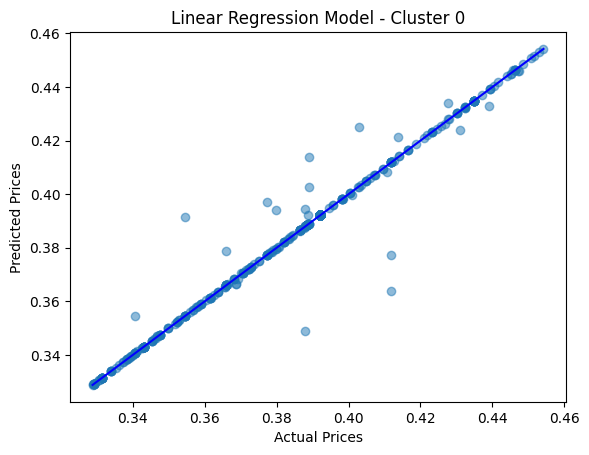

Cluster 1 - Cross-validation scores:  [0.93488739 0.58235208 0.96975302 0.9798095  0.9898813 ]
Cluster 1 - Mean cross-validation score: 0.89
Cluster 1 - Feature importances:
    RESIDENTIAL_UNITS: 0.0069
     COMMERCIAL_UNITS: 0.0126
          TOTAL_UNITS: 0.0113
     LAND_SQUARE_FEET: 0.1669
    GROSS_SQUARE_FEET: 0.8024
Cluster 1 - Root Mean Squared Error: 0.01
Cluster 1 - R squared for the training data is 0.991
Cluster 1 - Score against test data: 0.898


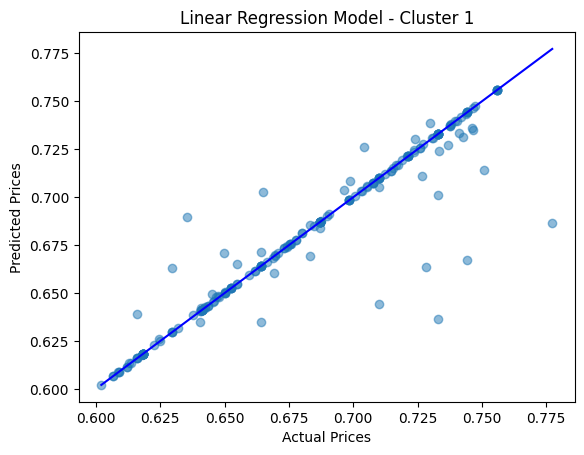

Cluster 2 - Cross-validation scores:  [0.97317534 0.93222673 0.99605079 0.99999555 0.96338696]
Cluster 2 - Mean cross-validation score: 0.97
Cluster 2 - Feature importances:
    RESIDENTIAL_UNITS: 0.0026
     COMMERCIAL_UNITS: 0.0005
          TOTAL_UNITS: 0.0026
     LAND_SQUARE_FEET: 0.7979
    GROSS_SQUARE_FEET: 0.1964
Cluster 2 - Root Mean Squared Error: 0.01
Cluster 2 - R squared for the training data is 0.996
Cluster 2 - Score against test data: 0.951


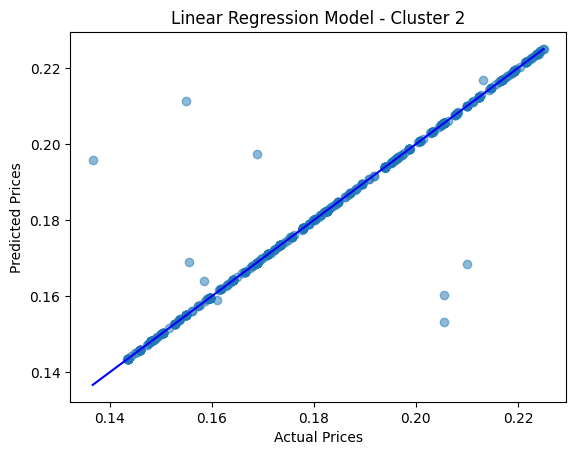

Cluster 3 - Cross-validation scores:  [0.94148441 0.92510013 0.97194801 0.98782862 0.97165426]
Cluster 3 - Mean cross-validation score: 0.96
Cluster 3 - Feature importances:
    RESIDENTIAL_UNITS: 0.0009
     COMMERCIAL_UNITS: 0.0003
          TOTAL_UNITS: 0.0018
     LAND_SQUARE_FEET: 0.3274
    GROSS_SQUARE_FEET: 0.6697
Cluster 3 - Root Mean Squared Error: 0.00
Cluster 3 - R squared for the training data is 0.978
Cluster 3 - Score against test data: 0.939


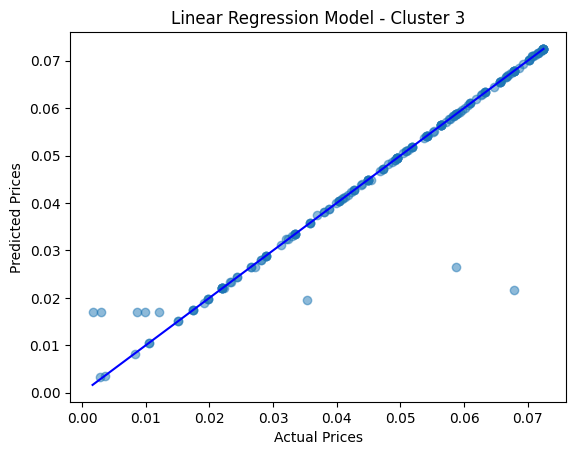

Cluster 4 - Cross-validation scores:  [0.99728356 0.9095474  0.99300673 0.97336595 0.97905091]
Cluster 4 - Mean cross-validation score: 0.97
Cluster 4 - Feature importances:
    RESIDENTIAL_UNITS: 0.0056
     COMMERCIAL_UNITS: 0.0016
          TOTAL_UNITS: 0.0079
     LAND_SQUARE_FEET: 0.2880
    GROSS_SQUARE_FEET: 0.6969
Cluster 4 - Root Mean Squared Error: 0.00
Cluster 4 - R squared for the training data is 0.996
Cluster 4 - Score against test data: 0.984


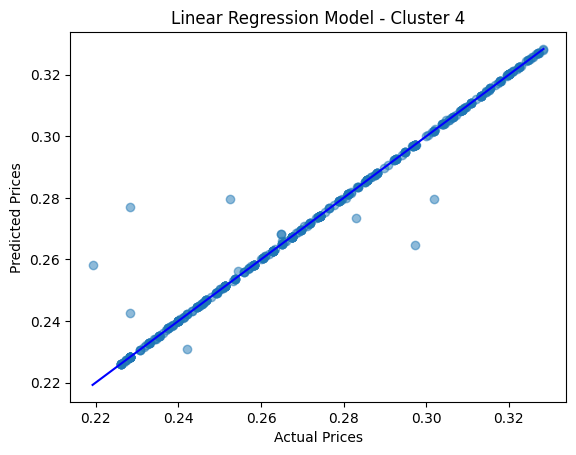

Cluster 5 - Cross-validation scores:  [0.90197583 0.80128204 0.93182693 0.93827591 0.87469447]
Cluster 5 - Mean cross-validation score: 0.89
Cluster 5 - Feature importances:
    RESIDENTIAL_UNITS: 0.0070
     COMMERCIAL_UNITS: 0.0054
          TOTAL_UNITS: 0.0251
     LAND_SQUARE_FEET: 0.1765
    GROSS_SQUARE_FEET: 0.7861
Cluster 5 - Root Mean Squared Error: 0.02
Cluster 5 - R squared for the training data is 0.984
Cluster 5 - Score against test data: 0.929


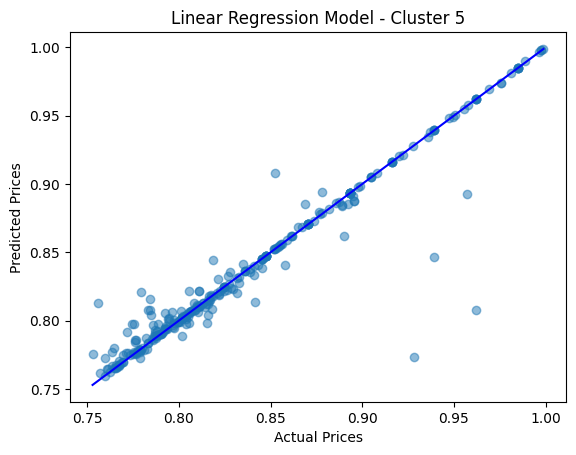

Cluster 6 - Cross-validation scores:  [0.98103473 0.9734743  0.99921321 0.98245418 0.9879085 ]
Cluster 6 - Mean cross-validation score: 0.98
Cluster 6 - Feature importances:
    RESIDENTIAL_UNITS: 0.0021
     COMMERCIAL_UNITS: 0.0003
          TOTAL_UNITS: 0.0024
     LAND_SQUARE_FEET: 0.4748
    GROSS_SQUARE_FEET: 0.5204
Cluster 6 - Root Mean Squared Error: 0.00
Cluster 6 - R squared for the training data is 0.998
Cluster 6 - Score against test data: 0.968


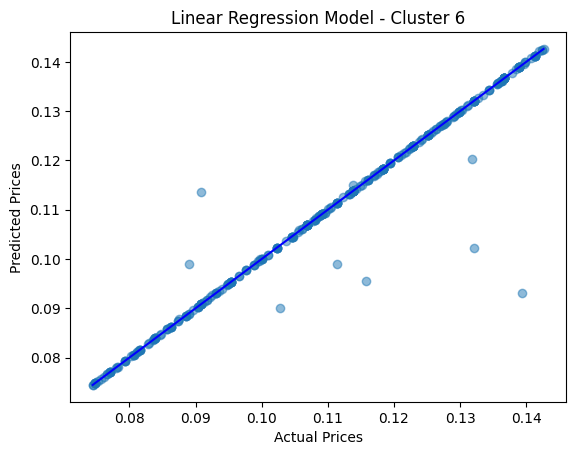

Cluster 7 - Cross-validation scores:  [0.96410015 0.64825165 0.96795484 0.99900694 0.96866582]
Cluster 7 - Mean cross-validation score: 0.91
Cluster 7 - Feature importances:
    RESIDENTIAL_UNITS: 0.0092
     COMMERCIAL_UNITS: 0.0062
          TOTAL_UNITS: 0.0084
     LAND_SQUARE_FEET: 0.0800
    GROSS_SQUARE_FEET: 0.8962
Cluster 7 - Root Mean Squared Error: 0.01
Cluster 7 - R squared for the training data is 0.990
Cluster 7 - Score against test data: 0.943


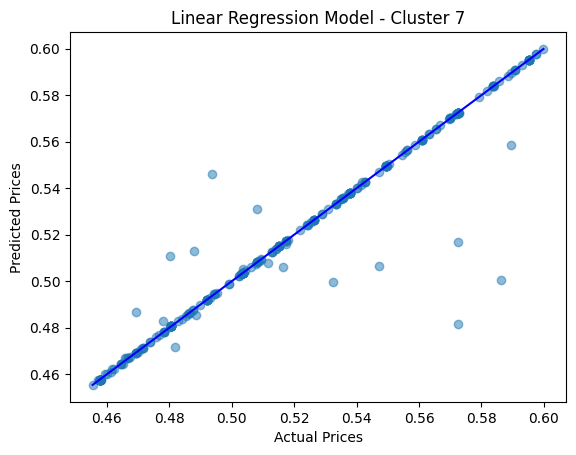

In [229]:
testClusters(dfnorm, models, clusters)